In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
import os
from scipy.sparse import coo_matrix
import warnings
warnings.filterwarnings('ignore')

Data Loaadng and Preprocessing

In [2]:
 
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv',sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [3]:
train_data.head(1)

,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Currency,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key
0,1705736792d82aa2f2d3caf1c07c53f4,2020-09-24 03:21:12 +0000,NaN,2e17bf4acecdece67fc00f07ad62c910,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,NaN,NaN,NaN,81350af1be98d3753cf964709f0c766a


In [4]:
#only keeping the importnat columns
train_data = train_data[['Uniq Id','Product Id','Product Rating','Product Reviews Count','Product Category','Product Brand','Product Name',
                        'Product Image Url', 'Product Description','Product Tags']]
train_data.head(1)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."


In [5]:
train_data.shape

(5000, 10)

In [6]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [7]:
#Filling the missing data
train_data['Product Rating'].fillna(0,inplace=True)
train_data['Product Reviews Count'].fillna(0,inplace=True)
train_data['Product Category'].fillna('',inplace=True)
train_data['Product Brand'].fillna('',inplace=True)
train_data['Product Description'].fillna('',inplace=True)

In [8]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [9]:
train_data.describe()

,Product Rating,Product Reviews Count
count,5000.000000,5000.000000
mean,1.884480,382.137000
std,2.192057,2050.994303
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,3.000000
75%,4.400000,60.250000
max,5.000000,29242.000000


In [10]:
train_data.duplicated().sum()
#No duplicate va;ue found

np.int64(0)

In [11]:
#Renaming the columns 
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating':'Rating',
    'Product Reviews Count':'ReviewCount',
    'Product Category':'Category',
    'Product Brand':"Brand",
    'Product Image Url': 'ImageURL',
    'Product Description':'Description',
    'Product Tags':'Tags',
    'Product Contents':  'Contents'
}
train_data.rename(columns=column_name_mapping,inplace=True)
train_data.columns

Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand',
       'Product Name', 'ImageURL', 'Description', 'Tags'],
      dtype='object')

In [12]:
train_data['ID']=train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID']=train_data['ProdID'].str.extract(r'(\d+)').astype(float)
# Here we remove all the alphabets from the ID using the extract function "\d+ removes the letters"

In [13]:
train_data.head(4)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Product Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."


Exploratory Data Analysis (EDA)

In [14]:

print("Number of Unique Users: ",train_data['ID'].nunique())
print("Number of Unique Products: ",train_data['ProdID'].nunique())
print("Number of Unique Ratings: ",train_data['Rating'].nunique())

Number of Unique Users:  1721
Number of Unique Products:  1697
Number of Unique Ratings:  36


<function matplotlib.pyplot.show(close=None, block=None)>

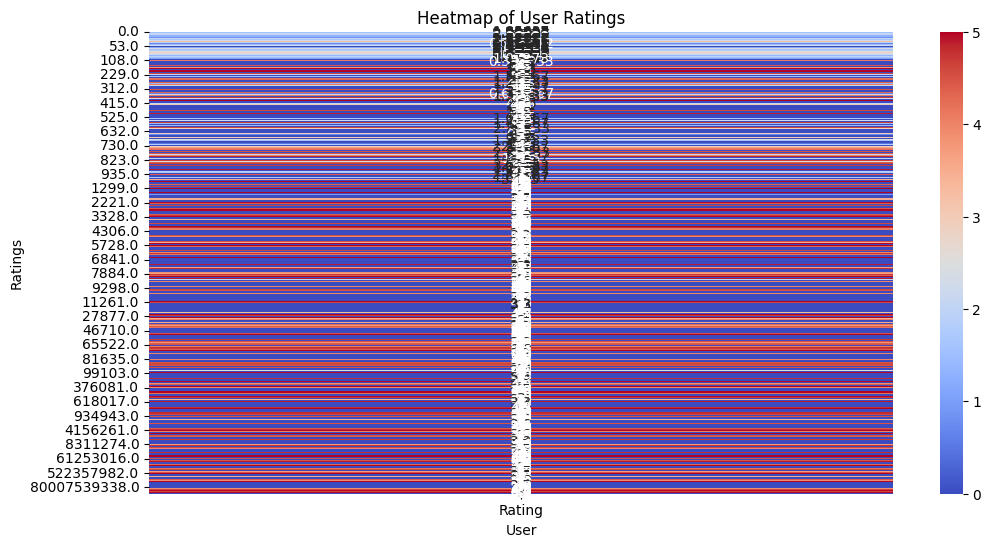

In [15]:
heatmap = train_data.pivot_table(index='ID', values='Rating', aggfunc='mean')
plt.figure(figsize = (12,6))
sns.heatmap(data=heatmap,annot=True,fmt='g',cmap='coolwarm',cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel("User")
plt.ylabel('Ratings')
plt.show

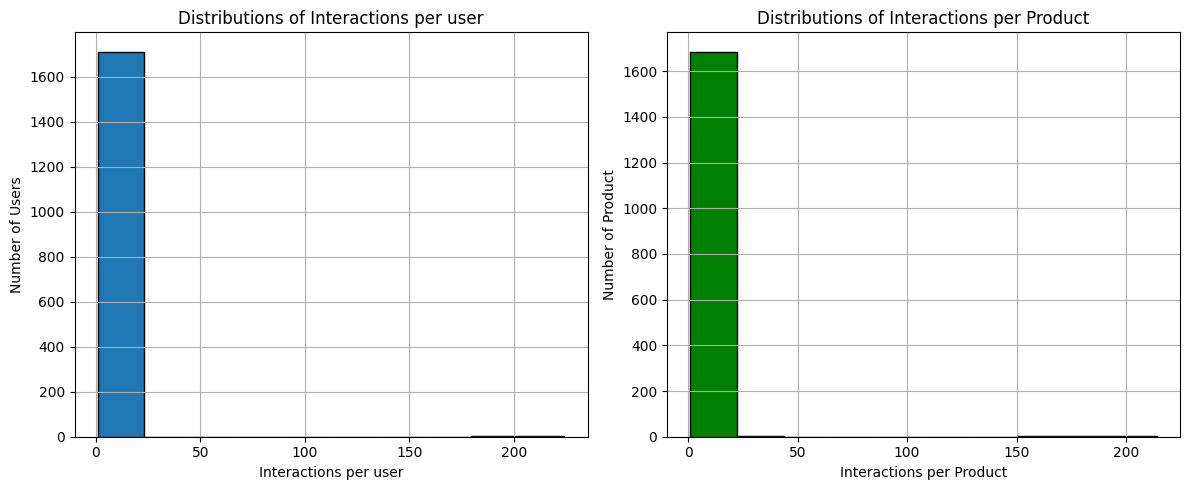

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
train_data['ID'].value_counts().hist(bins=10,edgecolor='k')
plt.xlabel('Interactions per user')
plt.ylabel('Number of Users')
plt.title('Distributions of Interactions per user')

plt.subplot(1,2,2)
train_data['ProdID'].value_counts().hist(bins=10,edgecolor='k',color='green')
plt.xlabel('Interactions per Product')
plt.ylabel('Number of Product')
plt.title('Distributions of Interactions per Product')

plt.tight_layout()
plt.show()
#From the graph we can say tht user interactions are very less

Text(0.5, 1.0, 'Most popular product slaes')

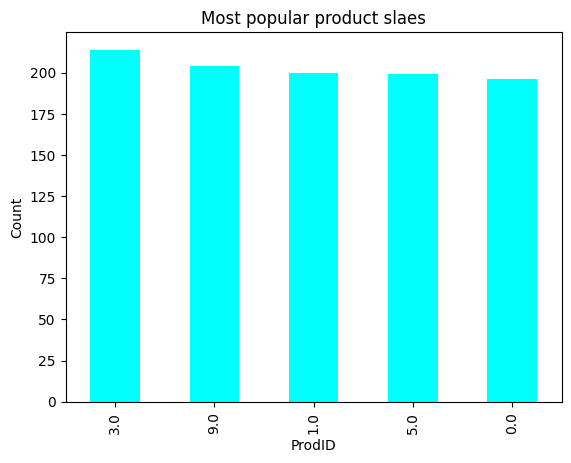

In [17]:
popular_product = train_data['ProdID'].value_counts().head(5)
popular_product.plot(kind='bar',color='cyan')
plt.ylabel("Count")
plt.title("Most popular product slaes")

Text(0, 0.5, 'Count')

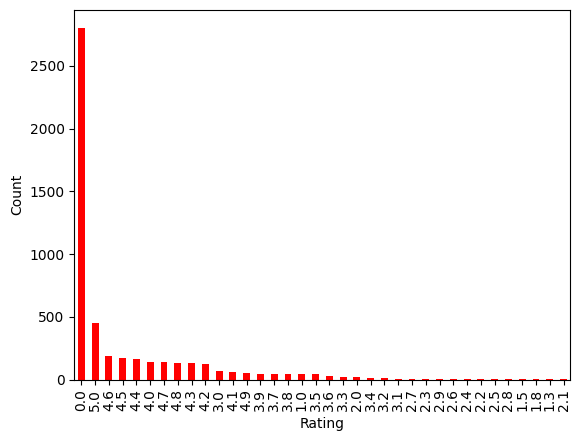

In [18]:
train_data['Rating'].value_counts().plot(kind='bar',color = 'red')
plt.ylabel("Count")

Data cleaning and Tags

In [19]:

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")
print("Model Loaded Successfully")

Model Loaded Successfully


In [20]:
def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
 #extract all except numbers and text not in STOP WORDS
    return ','.join(tags)

extract_tags = ['Category','Brand','Description']
for columns in extract_tags:
    train_data[columns] = train_data[columns].apply(clean_and_extract_tags)

In [21]:
#concatenate all the columns needed 
train_data['Tags'] = train_data[extract_tags].apply(lambda row:','.join(row), axis=1)

In [22]:
train_data.head(1)
#here you can see the Tags created

,ID,ProdID,Rating,ReviewCount,Category,Brand,Product Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium,beauty,premium,makeup,premium,nail,pol...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium,beauty,premium,makeup,premium,nail,pol..."


Rating Based Recommendation System

In [23]:
average_rating = train_data.groupby(['Product Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()
top_items = average_rating.sort_values(by='Rating',ascending=False)
rating_based_recomm = top_items.head(10)
rating_based_recomm

,Product Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter,thomas,roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt,bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
1208,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,"clay,park,labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1.0,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5.0
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1.0,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5.0
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4.0,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5.0
33,($55 Value) Clarins Multi-Active Day Face Crea...,2.0,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5.0


In [24]:
rating_based_recomm['Rating'] = rating_based_recomm['Rating'].astype(int)
rating_based_recomm['ReviewCount'] = rating_based_recomm['ReviewCount'].astype(int)

In [25]:
print("Rating Based Recommendation of Trending Products")
rating_based_recomm[['Product Name','Rating','ReviewCount','Brand','ImageURL']] = rating_based_recomm[['Product Name','Rating','ReviewCount','Brand','ImageURL']]
rating_based_recomm

Rating Based Recommendation of Trending Products


,Product Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1,"peter,thomas,roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10,"burt,bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5
1208,Clairol Professional Beautiful Collection Semi...,1,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13,"clay,park,labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5
33,($55 Value) Clarins Multi-Active Day Face Crea...,2,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5


Content Based Recommendation (Logic)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# TfidfVectorizer (Term-Frequency Inverse Doucment Frequency Vectorizer) converts text data into numerical data

In [27]:
tfidf = TfidfVectorizer(stop_words='english')
#the vectorizer will automatically exclude common English stop words (e.g., "the," "is," "and") 
# from the text before computing the Term Frequency-Inverse Document Frequency (TF-IDF) scores.
tfidf_matrix = tfidf.fit_transform(train_data['Tags'])

In [28]:
cosine = cosine_similarity(tfidf_matrix,tfidf_matrix)
cosine

array([[1.        , 0.00347577, 0.00363226, ..., 0.13535785, 0.31726435,
        0.05689108],
       [0.00347577, 1.        , 0.38086046, ..., 0.02315363, 0.00183907,
        0.0381051 ],
       [0.00363226, 0.38086046, 1.        , ..., 0.03960089, 0.00192187,
        0.0591094 ],
       ...,
       [0.13535785, 0.02315363, 0.03960089, ..., 1.        , 0.00123005,
        0.0379399 ],
       [0.31726435, 0.00183907, 0.00192187, ..., 0.00123005, 1.        ,
        0.00544407],
       [0.05689108, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00544407,
        1.        ]])

In [29]:
item_name = 'The Art of Shaving Mens Hair Styling Gel, Juniper Scent, 2 Fl Oz'
item_index = train_data[train_data['Product Name'] == item_name].index[0]

In [30]:
#example usage o one row
similar_items = list(enumerate(cosine[item_index]))
similar_items = sorted(similar_items,key = lambda x:x[1],reverse=True)

In [31]:
# Top 1- prodouct which are similar to the prodouct searched
top_similar = similar_items[1:10]
recommended_prodouct = [x[0] for x in top_similar ] # this gives the index of the similar prodoucts 

In [32]:
train_data.iloc[recommended_prodouct][['Product Name','Brand','ReviewCount']]

,Product Name,Brand,ReviewCount
1844,"American Crew Firm Hold Styling Hair Gel, 13.1...","american,crew",2.0
2858,Healing Solutions - Juniper Berry Oil (10ml) 1...,"healing,solutions",1.0
2416,Axe Whatever Messy Look Paste Hair Styling Pom...,"axe,hair,care",0.0
4340,"American Crew Forming Cream, 1.75 oz","american,crew",1.0
1458,(29% Off Deal) Its a 10 Miracle Firm Hold Hair...,10,5.0
1719,"(26% Off Deal) Its A 10 Miracle Styling Cream,...",10,9.0
3320,The Art of Shaving Lexington Collection Handcr...,"art,shaving",2.0
96,"Redken Mess Around 10 Disrupting Cream Paste, ...",redken,10.0
2188,Redken Curvaceous Spiral Look High-Hold Hair G...,redken,6.0


Content Based Recommendation Function (user Defined)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [106]:
def content_recommendation(train_data,item_name,top_n=10):
    if item_name not in train_data['Product Name'].values:
        print("Product ",item_name," Not Found")
        return pd.DataFrame()
    tfid = TfidfVectorizer(stop_words = 'english')
    tfid_matrix = tfid.fit_transform(train_data['Tags'])
    cosine = cosine_similarity(tfid_matrix,tfid_matrix)
    item_index = train_data[train_data['Product Name'] == item_name].index[0]
    similar_items = list(enumerate(cosine[item_index]))
    similar_items = sorted(similar_items,key = lambda x:x[1],reverse=True)
    top_similar = similar_items[1:top_n+1]
    recommended_prodouct = [x[0] for x in top_similar]
    details = train_data.iloc[recommended_prodouct][['Product Name','Brand','ReviewCount','ImageURL','Rating']]
    return details

In [107]:
#print(train_data['Product Name'][3])
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_recommendation(train_data,item_name,9)

,Product Name,Brand,ReviewCount,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...","kokie,cosmetics",0.0,https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....","kokie,cosmetics",0.0,https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",colors,3.0,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,"kokie,cosmetics",7.0,https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,cosmetics,0.0,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",paris,495.0,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,"kokie,cosmetics",7.0,https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,"city,color",2.0,https://i5.walmartimages.com/asr/4425a13e-085f...,3.0
4541,Be Matte Lipstick - Soft Pink,"city,color",2.0,https://i5.walmartimages.com/asr/69e1ec63-be5e...,3.0


Collaborative Filtering (Logic)

A technique used in recommendation systems to make predictions about a user's preference based on the preferences of many user.

In [44]:
user_rating_matrix =  train_data.pivot_table(index = 'ID',columns='ProdID',values='Rating',aggfunc='mean').fillna(0).astype(int)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(user_rating_matrix)

In [50]:
tarhet_id = 9
target_index = user_rating_matrix.index.get_loc(tarhet_id)

In [58]:
user_similarities = user_similarity[target_index]
similar_user_indices = user_similarities.argsort()[::-1][1:] # descending order excludong the target_index


In [62]:
recommended_items = []
for user_index in similar_user_indices:
    rated_by_user = user_rating_matrix.iloc[user_index]
    not_rated_by_user = (rated_by_user == 0) & (user_rating_matrix.iloc[target_index]==0)
    recommended_items.extend(user_rating_matrix.columns[not_rated_by_user][:10])


In [70]:
recommend_product_details = train_data[train_data['ProdID'].isin(recommended_items)][['Product Name','ReviewCount','Brand','ImageURL','Rating']]
recommend_product_details

,Product Name,ReviewCount,Brand,ImageURL,Rating
16,Daily Concepts Daily Body Scrubber,10.0,"daily,concepts",https://i5.walmartimages.com/asr/d3e7679d-781e...,4.4
27,9 Types Women Reusable Washable Panty Liner Ba...,0.0,hilitand,https://i5.walmartimages.com/asr/dbfd76a2-cd16...,0.0
42,Medline Aloetouch PROTECT Dimethicone Skin Pro...,1.0,medline,https://i5.walmartimages.com/asr/ac8c39d4-4241...,2.0
52,100% Pure Aloe Vera Gel (5-Pack) - Organic Max...,19.0,"simple,wonders",https://i5.walmartimages.com/asr/a2c5c82e-6f82...,4.7
53,"Natracare Panty Liners, Ultra Thin, 22 Ct",2.0,natracare,https://i5.walmartimages.com/asr/df1af3dd-caea...,3.0
...,...,...,...,...,...
4958,2-Piece Twin Size Bedding Comforter Set All-se...,11.0,"unique,bargains",https://i5.walmartimages.com/asr/42f1413f-acc3...,4.2
4967,"ALES GROUP Phyto Volumizing Shampoo, 6.7 oz",0.0,phyto,https://i5.walmartimages.com/asr/9876e817-64ed...,0.0
4978,(2 pack) Dr Teals Super Moisturizer Avocado Oi...,42.0,"dr,teal",https://i5.walmartimages.com/asr/9a5521dd-c151...,4.6
4987,2oz - Artizen Breathe Blend Essential Oil (100...,1.0,artizen,https://i5.walmartimages.com/asr/99ddd317-013e...,5.0


Collaborative Reommendation (User defined function)

In [115]:
def collaborative_filtering(train_data, target_id, top_n=10):
    user_rating_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)
    user_similarity = cosine_similarity(user_rating_matrix)
    target_index = user_rating_matrix.index.get_loc(target_id)
    user_similarities = user_similarity[target_index]
    similar_users = user_similarities.argsort()[::-1][1:]
    recommended_products = []
    for user_index in similar_users:
        rated_by_user = user_rating_matrix.iloc[user_index]
        not_rated_by_target = (rated_by_user > 0) & (user_rating_matrix.loc[target_id] == 0)
        recommended_products.extend(user_rating_matrix.columns[not_rated_by_target][:top_n])
    recommend_product_details = train_data[
        train_data['ProdID'].isin(recommended_products)
    ][['Product Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']].drop_duplicates()
    return recommend_product_details

target_id = 12
top_n = 6
ans = collaborative_filtering(train_data,target_id,top_n)
print("Top",top_n,"Recommendation for User:",target_id)
ans

Top 6 Recommendation for User: 12


,Product Name,ReviewCount,Brand,ImageURL,Rating
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",0.0,opi,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0.0
1,"Nice n Easy Permanent Color, 111 Natural Mediu...",0.0,easy,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,0.0
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
4,"Gillette TRAC II Plus Razor Blade Refills, Fit...",131.0,gillette,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,0.0
5,Old Spice Artisan Styling High Hold Matte Fini...,52.0,"old,spice",https://i5.walmartimages.com/asr/73214b95-72ce...,4.6
...,...,...,...,...,...
4995,"Garden Mint Room Spray (Double Strength), 4 ou...",2.0,"eclectic,lady",https://i5.walmartimages.com/asr/0e0416ae-6b70...,4.5
4996,Garnier Nutrisse Nourishing Hair Color Creme (...,7484.0,garnier,https://i5.walmartimages.com/asr/24d7a837-51f8...,3.9
4997,"Nail File Electric Drill, 6 in 1 Professional ...",4.0,stoneway,https://i5.walmartimages.com/asr/d6202179-2c93...,0.0
4998,Creed Love In Black Hair And Body Wash 6.8oz/2...,0.0,creed,https://i5.walmartimages.com/asr/3dc99239-66d2...,0.0


Hybrid Based Recommendation

In [119]:
def hybrid_recommendation(train_data,target_user_id,item_name,top_n=10):
    content_basec_recomm = content_recommendation(train_data,item_name,top_n)
    collaborative_based_recomm = collaborative_filtering(train_data,target_user_id,top_n)
    hybird_recomm = pd.concat([content_basec_recomm,collaborative_based_recomm]).drop_duplicates()
    return hybird_recomm.head(10)

target_user_id = 890
#print(train_data['Product Name'].iloc[5])
item_name = 'Old Spice Artisan Styling High Hold Matte Finish Molding Clay, 2.64 oz'
top_n=10
ans = hybrid_recommendation(train_data,target_user_id,item_name,top_n)
print("Top:",top_n,'Recommendation for User:',target_user_id,'for product:',item_name)
ans


Top: 10 Recommendation for User: 890 for product: Old Spice Artisan Styling High Hold Matte Finish Molding Clay, 2.64 oz


,Product Name,Brand,ReviewCount,ImageURL,Rating
339,Old Spice Wild Collection Bearglove Mens Deodo...,"old,spice",19.0,https://i5.walmartimages.com/asr/be1a76a3-88a6...,4.2
1934,Old Spice Fresher Collection Deep Sea Invisibl...,"old,spice",256.0,https://i5.walmartimages.com/asr/137049af-32ee...,4.4
1554,"Old Spice Ultra Smooth Deodorant, Fresh Start,...","old,spice",504.0,https://i5.walmartimages.com/asr/1dea23e2-1122...,4.7
3725,Old Spice High Endurance Original Anti-Perspir...,"old,spice",92.0,https://i5.walmartimages.com/asr/a0a4af40-75b3...,3.7
1282,"($25 Value) Old Spice Hair and Body Gift Set, ...","old,spice",24.0,https://i5.walmartimages.com/asr/14191050-a3b2...,0.0
2252,Old Spice Antiperspirant and Deodorant Invisib...,"old,spice",20.0,https://i5.walmartimages.com/asr/49b8ce0f-28f7...,0.0
552,(6 pack) Old Spice Classic Original Deodorant ...,"old,spice",352.0,https://i5.walmartimages.com/asr/fa4947ea-dffc...,0.0
477,Old Spice Yetifrost Scent Body Wash with Cooli...,"old,spice",78.0,https://i5.walmartimages.com/asr/1b3690d8-f731...,0.0
2065,"Old Spice Mens 2 in 1 Shampoo & Conditioner, S...","old,spice",87.0,https://i5.walmartimages.com/asr/9487e854-92e3...,4.4
2448,Old Spice High Endurance Original Scent Deodor...,"old,spice",290.0,https://i5.walmartimages.com/asr/69e44d4d-dd83...,3.1
